# ResNet50 baseline training for rotation (pose estimation)

This notebook allows you to:
1. **Import and setup**
2. **Load LineMOD dataset**
3. **Initialize PoseEstimatorBaseline** (ResNet-50 backbone, rotation only)
4. **Name and path for training and loading a model**
5. **Training**
6. **Evaluation on test set** (rotation metrics only)

## 1. Import and Setup

In [1]:
import sys
from pathlib import Path
import torch
from torch import optim
import yaml
from pathlib import Path
import random
import numpy as np
import pandas as pd

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from dataset.linemod_pose import create_pose_dataloaders
from utils.visualization import plot_training_validation_loss_from_csv, show_pose_samples_with_add, plot_add_per_class, plot_pinhole_error_per_class, calc_add_accuracy_per_class, calc_pinhole_error_per_class
from utils.training import train_pose_baseline
from utils.losses import PoseLossBaseline
from utils.transforms import quaternion_to_rotation_matrix_batch
from utils.metrics import compute_add_batch_rotation_only
from utils.file_io import load_all_models, load_models_info, load_validation_results
from models.pose_estimator_baseline import PoseEstimatorBaseline
from utils.validation import run_pinhole_deep_pipeline


## 2. Load LineMOD dataset

In [ ]:
DATASET_DIR = Path(Config.DATASETS_DIR)
if not DATASET_DIR.exists():
    print("Dataset not found, start downloading...")
    from utils.download_dataset import download_linemod_dataset
    download_linemod_dataset()
else:
    print("Dataset LineMOD present.")

In [2]:
# Load the train, val, and test dataloaders
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 30 | Val batches: 8 | Test batches: 210


## 3. Initialize PoseEstimatorBaseline model

In [3]:
# Initialize the baseline model for rotation only (ResNet-50)
model = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

# Show minimal info on the model
params_info = model.get_num_parameters()
print(f"PoseEstimatorBaseline model loaded on: {Config.DEVICE}")
print(f"Total parameters: {params_info['total']:,}")
print(f"Trainable parameters: {params_info['trainable']:,}")

PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (weights=ResNet50_Weights.IMAGENET1K_V1, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5
PoseEstimatorBaseline model loaded on: mps
Total parameters: 26,136,132
Trainable parameters: 26,136,132


## 4. Name and path for training and loading a model

In [4]:
NAME = "pose_rgb_baseline"

checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

## 5. Training (only rotation)

In [ ]:
# Baseline rotation training (PoseLossBaseline)
EPOCHS = Config.POSE_EPOCHS
LR = Config.POSE_LR
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Save args.yaml
args_dict = {
    'epochs': EPOCHS,
    'learning_rate': LR,
    'accumulation_steps': ACCUMULATION_STEPS,
    'batch_size': Config.POSE_BATCH_SIZE,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'device': str(Config.DEVICE),
    'crop_margin': Config.POSE_CROP_MARGIN,
    'output_size': Config.POSE_IMAGE_SIZE,
    'weight_decay': Config.POSE_WEIGHT_DECAY
}
checkpoint_dir.mkdir(parents=True, exist_ok=True)
with open(checkpoint_dir / "args.yaml", "w") as f:
    yaml.dump(args_dict, f)

criterion = PoseLossBaseline()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)

history, best_loss, best_epoch = train_pose_baseline(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=Config.DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_dir=str(checkpoint_dir),
    training_config=args_dict,
    save_best=True,
    save_last=True,
    verbose=True
)

print(f"\nBest loss: {best_loss:.4f} @ epoch {best_epoch+1}")
print("✅ Training completed!")

Epoch 1/2: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it, loss=1.9103]


Epoch 1: loss=2.0860, val_loss=1.6657
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_test/weights/best.pt


Epoch 2/2: 100%|██████████| 30/30 [00:32<00:00,  1.10s/it, loss=1.7856]


Epoch 2: loss=1.7420, val_loss=1.4370
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_test/weights/best.pt

Best loss: 1.7420 @ epoch 2
✅ Training completato!


### 5.1 Loss visualization

In [5]:
training_csv_path = checkpoint_dir / 'training_result.csv'
plot_training_validation_loss_from_csv(training_csv_path)

File not found: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/training_result.csv


## 6. Testing and Evaluation on Test Set Samples (rotation only)

In [6]:
NAME = "pose_rgb_baseline"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

### 6.1 Display prediction on batch images

✅ Model pose_rgb_baseline loaded and in eval mode!
Random batch: extracting random batch from test dataset
Random batch start index: 7638
Number of samples extracted: 64
Batch keys: ['rgb_crop', 'rgb', 'quaternion', 'translation', 'cam_K', 'bbox', 'folder_id', 'sample_id', 'obj_id', 'depth_path', 'rgb_path', 'info_path']

Converting quaternions to rotation matrices
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points

Computing ADD metric
Test completed on 64 samples

📊 Mean ADD on batch:
   Mean ADD: 5.0702 ± 2.1004


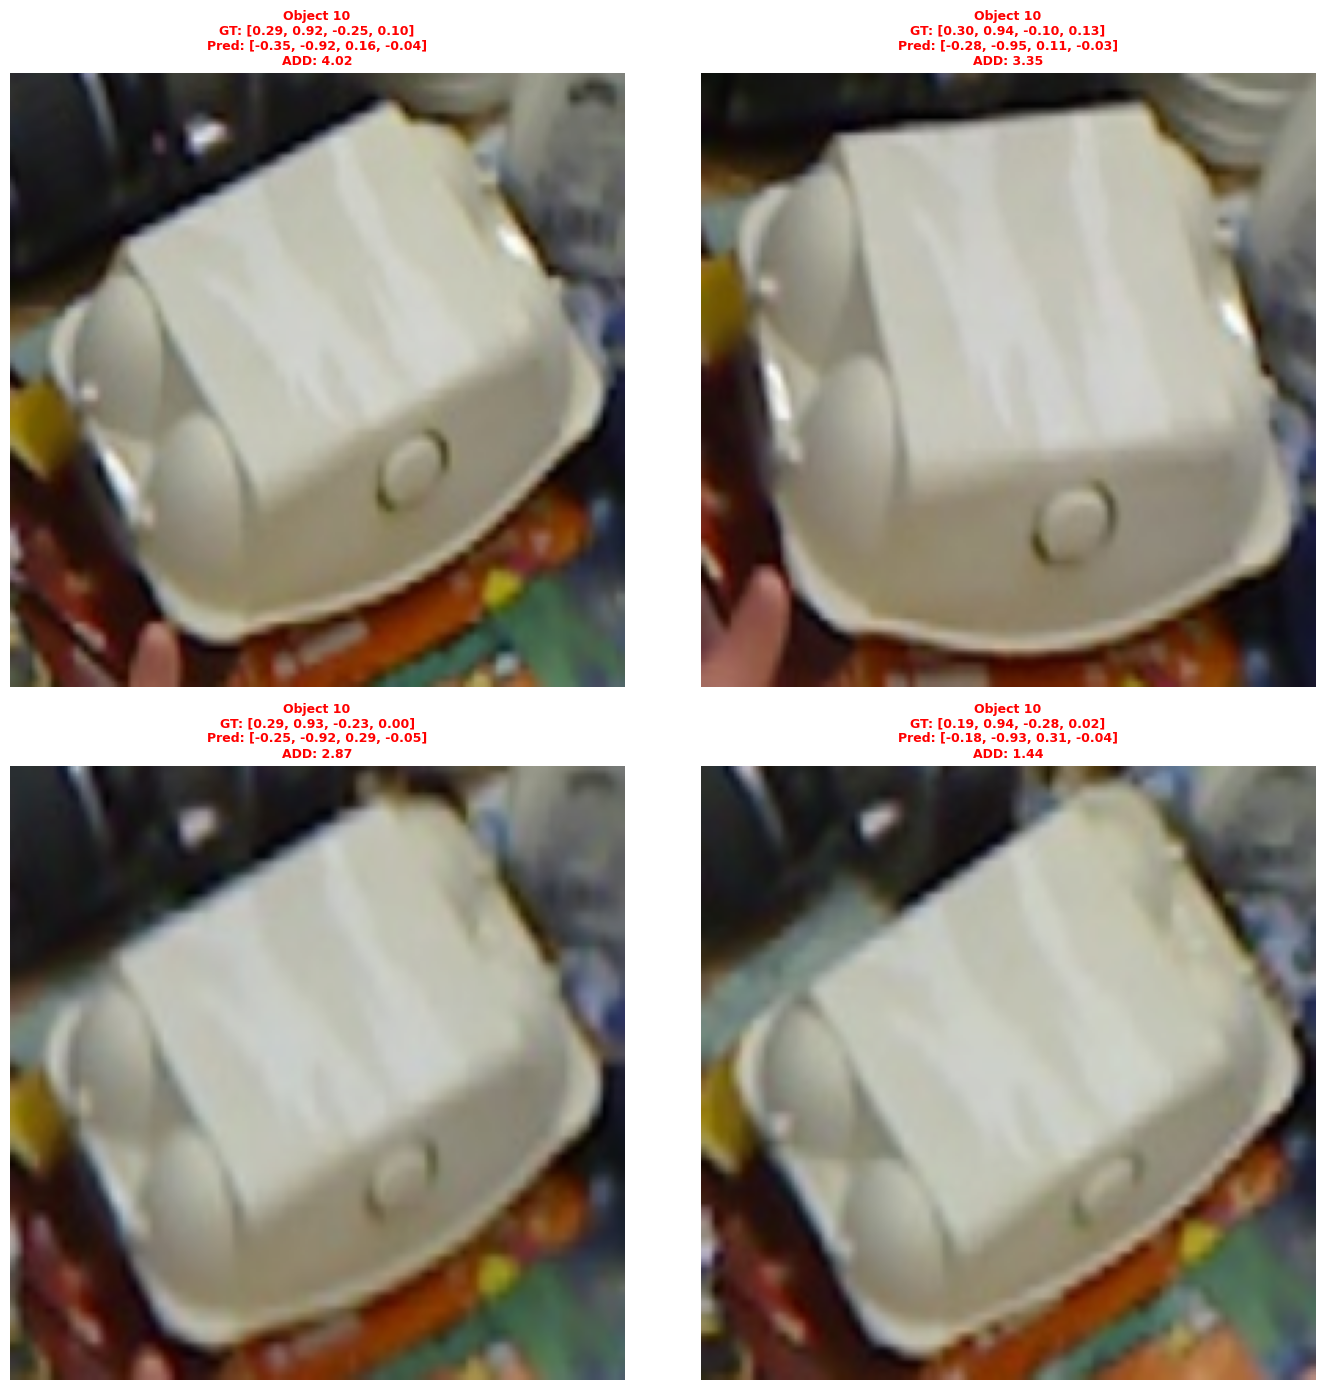

In [7]:
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Model {NAME} loaded and in eval mode!")
except Exception as e:
    print(f"⚠️  Model not found or already loaded. Error: {e}")
    raise SystemExit("Stop right there!")

print("Random batch: extracting random batch from test dataset")
random_start = random.randint(0, len(test_loader.dataset) - test_loader.batch_size)
print(f"Random batch start index: {random_start}")
indices = list(range(random_start, random_start + test_loader.batch_size)) # selected indices list
samples = [test_loader.dataset[i] for i in indices]
print(f"Number of samples extracted: {len(samples)}")

# Collate sample as DataLoader does
batch = {}
for k in samples[0]:
    values = [sample[k] for sample in samples]
    if isinstance(values[0], torch.Tensor):
        batch[k] = torch.stack(values)
    else:
        batch[k] = values
print(f"Batch keys: {list(batch.keys())}")
test_batch = batch

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions = model(images)

# Conversion of quaternions into rotation matrices
print("\nConverting quaternions to rotation matrices")
pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions)

# Compute ADD
models_dict = load_all_models()
models_info = load_models_info(Config.LINEMOD_ROOT / "models" / "models_info.yml")

print("\nComputing ADD metric")
results = compute_add_batch_rotation_only(pred_R, gt_R, obj_ids.cpu().numpy() if hasattr(obj_ids, 'cpu') else obj_ids, models_dict, models_info)

rot_errors = results.get('add_values', None)
print(f"Test completed on {len(images)} samples")
print(f"\n📊 Mean ADD on batch:")
print(f"   Mean ADD: {np.mean(rot_errors):.4f} ± {np.std(rot_errors):.4f}")

show_pose_samples_with_add(images, gt_quaternions, pred_quaternions, obj_ids, rot_errors)

### 6.2 Statistics on the entire test set

In [8]:
# Use PosePinholeDataset for pipeline pinhole+deep
run_pinhole_deep_pipeline(model, test_loader, NAME)

Model pose_rgb_baseline loaded
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validazione GT crops (baseline): 100%|██████████| 210/210 [02:51<00:00,  1.22it/s]


Concatenating batches...
Computing metrics: rotation-only ADD, full 6D ADD, pinhole translation error
Metrics computed
Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv


### 6.3 Table: Average ADD and Accuracy by Class

The following table shows the average ADD error and accuracy (percentage of correct poses) for each class (object) in the LineMOD dataset.

In [9]:
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
val_csv_path = checkpoint_dir / 'validation_result.csv'
if val_csv_path.exists():
    results_rot_only, results_pinhole = load_validation_results(val_csv_path)
    print(f"✅ Risultati caricati da {val_csv_path}")
else:
    results_rot_only = globals().get('results_rot_only', None)
    results_pinhole = globals().get('results_pinhole', None)
    if results_rot_only is None:
        print("⚠️  Devi prima calcolare la metrica ADD rot-only su tutto il test set e salvare i risultati in 'results_rot_only'.")

✅ Risultati caricati da /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv


In [10]:
# Table 1: Rotation performance (ADD rotation only, dummy translation)
if results_rot_only is not None:
    data, global_add, global_acc = calc_add_accuracy_per_class(results_rot_only, Config.LINEMOD_OBJECTS, use_6d=True)
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD (rot-only):", f"{global_add:.2f}")
    print("Accuracy globale (rot-only) (%):", f"{global_acc:.1f}")

# Table 2: Pinhole translation statistics
if results_pinhole is not None:
    data_pinhole, global_pinhole = calc_pinhole_error_per_class(results_pinhole, Config.LINEMOD_OBJECTS)
    df_pinhole = pd.DataFrame(data_pinhole)
    display(df_pinhole)
    print("\nErrore medio pinhole globale (mm):", f"{global_pinhole:.2f}")

# Table 3: Rotation + translation performance (ADD full pose)
from utils.visualization import calc_combined_results_per_class
if calc_combined_results_per_class is not None:
    data, global_add, global_acc, global_pinhole = calc_combined_results_per_class(results_rot_only, results_pinhole, Config.LINEMOD_OBJECTS)
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD (full pose):", f"{global_add:.2f}")
    print("Accuracy globale (full pose) (%):", f"{global_acc:.1f}")

,Class,ADD 6D (mm),Accuracy (%)
0,01 - ape,10.53,57.3
1,02 - benchvise,17.40,82.7
2,04 - camera,16.00,69.6
3,05 - can,18.11,73.2
4,06 - cat,9.85,88.4
5,08 - driller,21.82,74.0
6,09 - duck,12.96,48.1
7,10 - eggbox,4.83,100.0
8,11 - glue,5.02,99.3
9,12 - holepuncher,13.03,69.7



Media globale ADD (rot-only): 14.50
Accuracy globale (rot-only) (%): 76.9


,Class,Pinhole Error (mm)
0,01 - ape,12.13
1,02 - benchvise,28.73
2,04 - camera,26.16
3,05 - can,19.49
4,06 - cat,16.02
5,08 - driller,27.68
6,09 - duck,14.44
7,10 - eggbox,30.27
8,11 - glue,18.32
9,12 - holepuncher,15.01



Errore medio pinhole globale (mm): 22.33


,Class,ADD 6D (mm),Accuracy (%),Pinhole Error (mm)
0,01 - ape,10.53,57.3,12.13
1,02 - benchvise,17.40,82.7,28.73
2,04 - camera,16.00,69.6,26.16
3,05 - can,18.11,73.2,19.49
4,06 - cat,9.85,88.4,16.02
5,08 - driller,21.82,74.0,27.68
6,09 - duck,12.96,48.1,14.44
7,10 - eggbox,4.83,100.0,30.27
8,11 - glue,5.02,99.3,18.32
9,12 - holepuncher,13.03,69.7,15.01



Media globale ADD (full pose): 14.50
Accuracy globale (full pose) (%): 76.9


### 6.4 Graph: Average ADD by Class

The following graph shows the average ADD error for each class, providing an immediate visual comparison of the model's performance on different objects.

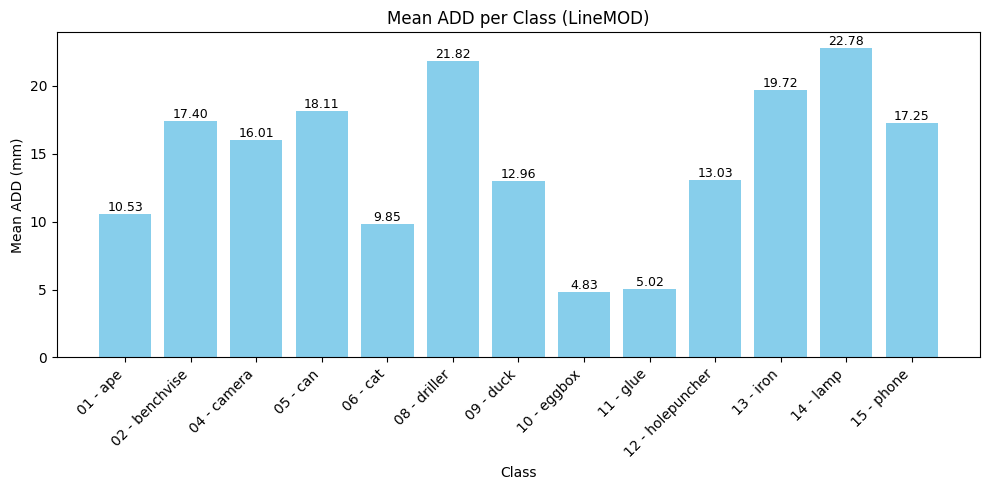

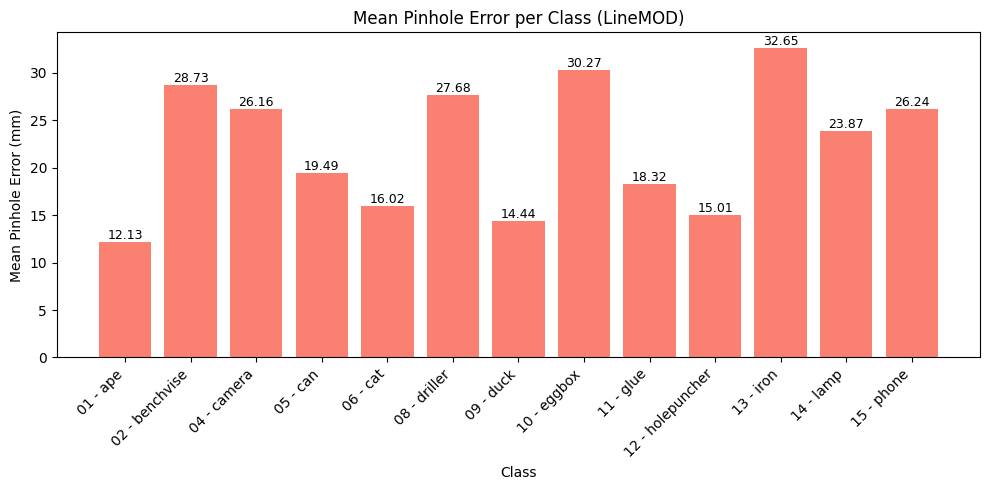

In [11]:
# Bar chart of ADD averages by class (rot-only)
results_rot_only = globals().get('results_rot_only', None)
if results_rot_only is None:
    print("⚠️  Devi prima calcolare la metrica ADD rot-only su tutto il test set e salvare i risultati in 'results_rot_only'.")
else:
    plot_add_per_class(results_rot_only, Config.LINEMOD_OBJECTS)

# Bar chart of average pinhole error by classresults_pinhole = globals().get('results_pinhole', None)
if results_pinhole is None:
    print("⚠️  Devi prima calcolare le statistiche di traslazione pinhole e salvarle in 'results_pinhole'.")
else:
    plot_pinhole_error_per_class(results_pinhole, Config.LINEMOD_OBJECTS)